In [1]:
%gui qt
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tifffile
import plotly.express as px
import glob
import napari
import umap
import hdbscan
import plotly.graph_objs as go

In [2]:
viewer = napari.Viewer()

In [3]:
def clear_layers():
    for i in range(0, len(viewer.layers)):
        viewer.layers.remove(viewer.layers[0].name)

In [4]:
mapper = pd.DataFrame()
for f in glob.glob('*analysis/*.csv'):
    tmp = pd.read_csv(f)
    tmp['Batch'] = (f.split('_')[0])
    mapper = pd.concat([mapper, tmp])
mapper['Plate'] = mapper['Plate'].str[-1]

In [5]:
training_data = np.load('Original.npy')
results = np.load('Encoded.npy')
latents = np.load('Latents.npy')
names = np.load('Names.npy')

In [6]:

reducer = umap.UMAP()

In [7]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(latents)

In [9]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=50,
).fit_predict(clusterable_embedding)

In [10]:
df = pd.DataFrame({'Name':names, 'Label':labels, 'X':clusterable_embedding[:,0], 'Y':clusterable_embedding[:,1] })
df['Label'] = 'C'+ df['Label'].astype(str)
df['Index'] = df.index

In [11]:
df['BatchPlate'] = df['Name'].str.split('/').str[-2]

In [12]:
df['Row'] = df['Name'].str.split('/').str[-1].str.split('_').str[0].str[0]
df['Column'] = df['Name'].str.split('/').str[-1].str.split('_').str[0].str[1:].str.zfill(2)
df['Well'] = df['Row']+df['Column']

In [13]:
df['Plate'] = df['BatchPlate'].str.split('_').str[1].str[-1]
df['Batch'] = df['BatchPlate'].str.split('_').str[0]

In [14]:
df = df.merge(mapper, on=['Batch', 'Plate', 'Well'])

In [30]:
batches = np.unique(df['Batch'])
batches

array(['20cy238', '20cy239', '20cy240', '20cy241'], dtype=object)

In [31]:
f=go.FigureWidget(
    px.scatter(df, x='X', y='Y', color='Batch', hover_data=['Index', 'Well', 'deletion'], height=600)
    )
     
                
def click_fn(trace, points, state):
    
    if (len(points.point_inds)>0):
        print(f.data[points.trace_index]['customdata'][points.point_inds[-1]])
        idx = f.data[points.trace_index]['customdata'][points.point_inds[-1]][0]
        clear_layers()
        viewer.add_image(training_data[idx], blending='additive', colormap='green')
        viewer.add_image(results[idx], blending='additive', colormap='magenta')

        

for a in f.data:
    a.on_click(click_fn)

f

#px.scatter(df, x='X', y='Y', color='Label', hover_data=['Well'])

FigureWidget({
    'data': [{'customdata': array([[0, 'I10', 'YER028C'],
                                   [1…

In [16]:
df['Label'].value_counts()

C1     3886
C0      249
C-1      20
Name: Label, dtype: int64

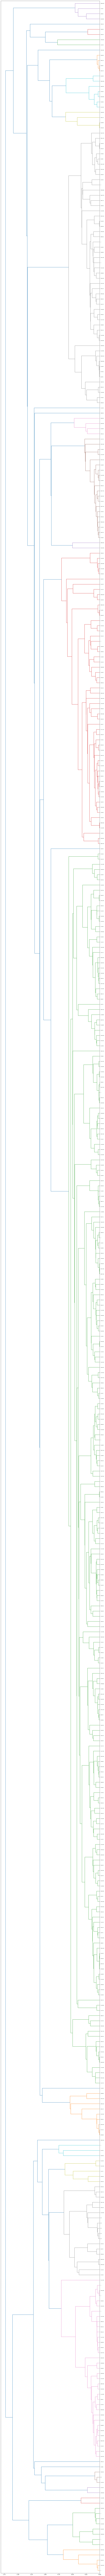

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

#linked = linkage(latents, 'single')
bdf = df[df['Batch']==batches[3]]
linked = linkage(bdf[['X', 'Y']].to_numpy(), 'single')

labelList = np.array(bdf['deletion'])

plt.figure(figsize=(15, 400))
rtn = dendrogram(linked,
            orientation='left',
                 color_threshold=0.8,
            labels=labelList,
            distance_sort='descending',
                 leaf_font_size=6,
            show_leaf_counts=True)

plt.savefig('ClusterDiagramB4_0.8.pdf')
plt.show()


In [55]:
import os

ordered = rtn['leaves']
batch_data = training_data[df['Batch']==batches[2]]
tmp = batch_data[ordered,:]
tmpnames = (bdf['deletion']).iloc[ordered]

#tifffile.imsave('ordered.tif', tmp.astype(np.single), imagej=True)

current_cluster='bob'
current_cluster_no = -1
ctr = 0
clusters =[]
for s in range(0,len(ordered)):
    if rtn['leaves_color_list'][s]!=current_cluster:
        current_cluster=rtn['leaves_color_list'][s]
        current_cluster_no=current_cluster_no+1
        ndir = './Clusters/'+str(current_cluster_no)
        try: 
            os.mkdir(ndir) 
        except OSError as error: 
            #print(error)  
            b=1
    tifffile.imsave(ndir+'/'+str(ctr).zfill(3)+'_'+tmpnames.iloc[s]+'.tif', tmp[s].astype(np.single), imagej=True)
    clusters.append(current_cluster_no)
    ctr=ctr+1
clusters = np.array(clusters)        

In [54]:
len(ordered)

496

In [199]:
tdf = pd.DataFrame({'Deletion':tmpnames, 'Group':clusters})
tdf.to_csv('Labeled.csv')

In [165]:
import sklearn
rtn = sp.spatial.distance.pdist(df.iloc[ordered][['X', 'Y']].to_numpy())
rtn = sp.spatial.distance.squareform(rtn)

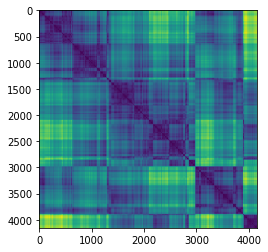

In [158]:
plt.imshow(rtn)

In [129]:
sp.df.iloc[ordered][['X', 'Y']].to_numpy()

array([[12.642023 ,  4.514412 ],
       [12.643031 ,  4.516428 ],
       [12.645885 ,  4.519716 ],
       ...,
       [-1.3302484,  3.436495 ],
       [-1.7709085,  3.3817177],
       [-1.2265153,  3.3362455]], dtype=float32)

In [45]:
import plotly.figure_factory as ff

import numpy as np

fig = ff.create_dendrogram(df[['X', 'Y']].to_numpy(), orientation='left', labels=np.array(df['deletion']))
#fig = ff.create_dendrogram(latents, orientation='left', labels=np.array(df['Well']))
fig.update_layout(width=800, height=2300)


fig.show()

In [28]:
df['deletion'].value_counts()

WT         5
YFL033C    2
YML112W    1
YNL011C    1
YER130C    1
          ..
YJR055W    1
YER044C    1
YBR020W    1
YIL111W    1
YGL176C    1
Name: deletion, Length: 212, dtype: int64